In [5]:
import numpy as np
# %matplotlib widget
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams.update({"text.usetex": True, "font.family": "Helvetica"})
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['lines.linewidth'] = 2.0
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12,8)
import pickle as pl
from sqlalchemy import create_engine
import healpy as hp
from tqdm import tqdm
from astropy.io import ascii
from utils import analysis as ana
from utils import binning
import scipy.interpolate
from matplotlib.ticker import MultipleLocator, LogLocator
import pandas as pd

# CHANGE THIS PATH IN ORDER TO MATCH THE PATH OF YOUR PACKAGE
PATH_PACKAGE = '/home/miguel/Desktop/PlanckBIRD-lens'

In [6]:
directory_plots = f'{PATH_PACKAGE}/notebooks/plots'
Nsim = 400
Nsim_MF = 100
lmax_LB = 1000
lmax_P = 2048
L_LB = np.arange(lmax_LB + 1)
factor_L_LB = (L_LB*(L_LB+1))**2/(2*np.pi)
L_P = np.arange(lmax_P + 1)
factor_L_P = (L_P*(L_P+1))**2/(2*np.pi)
qe_list = ['TT', 'TE', 'EE', 'TB', 'EB']
qe_list_MV = qe_list + ['MV']
auto_spectra_qe = [x + y for x, y in zip(qe_list_MV, qe_list_MV)]
noise_pairs = ['TTTT', 'TTTE', 'TTEE', 'TETE', 'TEEE', 'EEEE', 'TBTB', 'TBEB', 'EBEB']
noise_pairs_2 = ['TTTE', 'TTEE', 'TEEE', 'TBEB']

pairs = []
for i in range(len(qe_list)):
    for j in range(i, len(qe_list)):
        pairs.append(qe_list[i] + qe_list[j])
pairs_no_MV = list(pairs)
pairs.append('MVMV')
# Values of fsky, w2 and w4 for Planck's 80 % mask with an apodization scale of 2 degrees.
fsky = 0.7990690867106119
w2_LB = 0.7782862278400908
w4_LB = 0.7752966348731124
w2_P = 0.6788767002202918
w4_P = 0.6758500017222131

In [7]:
cls_phiphi = ascii.read(f"{PATH_PACKAGE}/input_files/base_2018_plikHM_TTTEEE_lowl_lowE_lensing_cl_lensed.dat",
                     format="commented_header", header_start=10).as_array()['6:phiphi'][:lmax_P + 1]*(L_P*(L_P+1))

## Plotting the binned results

In [8]:
fd = f"{PATH_PACKAGE}/data/binned_lensing_power_spectrum"
fg_arr = ['no_fg', 's1_d1_f1_a1_co1', 's5_d10_a1_f1_co3']
fname_LiteBIRD = f"LiteBIRD_fsky_0.8"
fname_Planck = f"Planck_fsky_0.7"
fname_Planck_LiteBIRD = f"LiteBIRD_Planck_fsky_0.8"

# Initialize the variables
c_L_b_LiteBIRD = []
c_L_b_Planck = []
c_L_b_Planck_LiteBIRD = []
for i, fg in enumerate(fg_arr):
    # MV weights
    c_L_b_LiteBIRD_aux = pl.load(open(f"{fd}/final_cl_b_debiased_MC_norm_binned_TT_TE_EE_TB_EB_{fg}_{fname_LiteBIRD}_MV.pkl",'rb'))
    c_L_b_Planck_aux = pl.load(open(f"{fd}/final_cl_b_debiased_MC_norm_binned_TT_TE_EE_TB_EB_{fg}_{fname_Planck}_MV.pkl",'rb'))
    c_L_b_Planck_LiteBIRD_aux = pl.load(open(f"{fd}/final_cl_b_debiased_MC_norm_binned_TT_TE_EE_TB_EB_{fg}_{fname_Planck_LiteBIRD}_MV.pkl",'rb'))
    
    c_L_b_LiteBIRD.append({qe: c_L_b_LiteBIRD_aux[qe] for qe in pairs})
    c_L_b_Planck.append({qe: c_L_b_Planck_aux[qe] for qe in pairs})
    c_L_b_Planck_LiteBIRD.append({qe: c_L_b_Planck_LiteBIRD_aux[qe] for qe in pairs})
B_LB = c_L_b_LiteBIRD_aux['B']
B_P = c_L_b_Planck_aux['B']

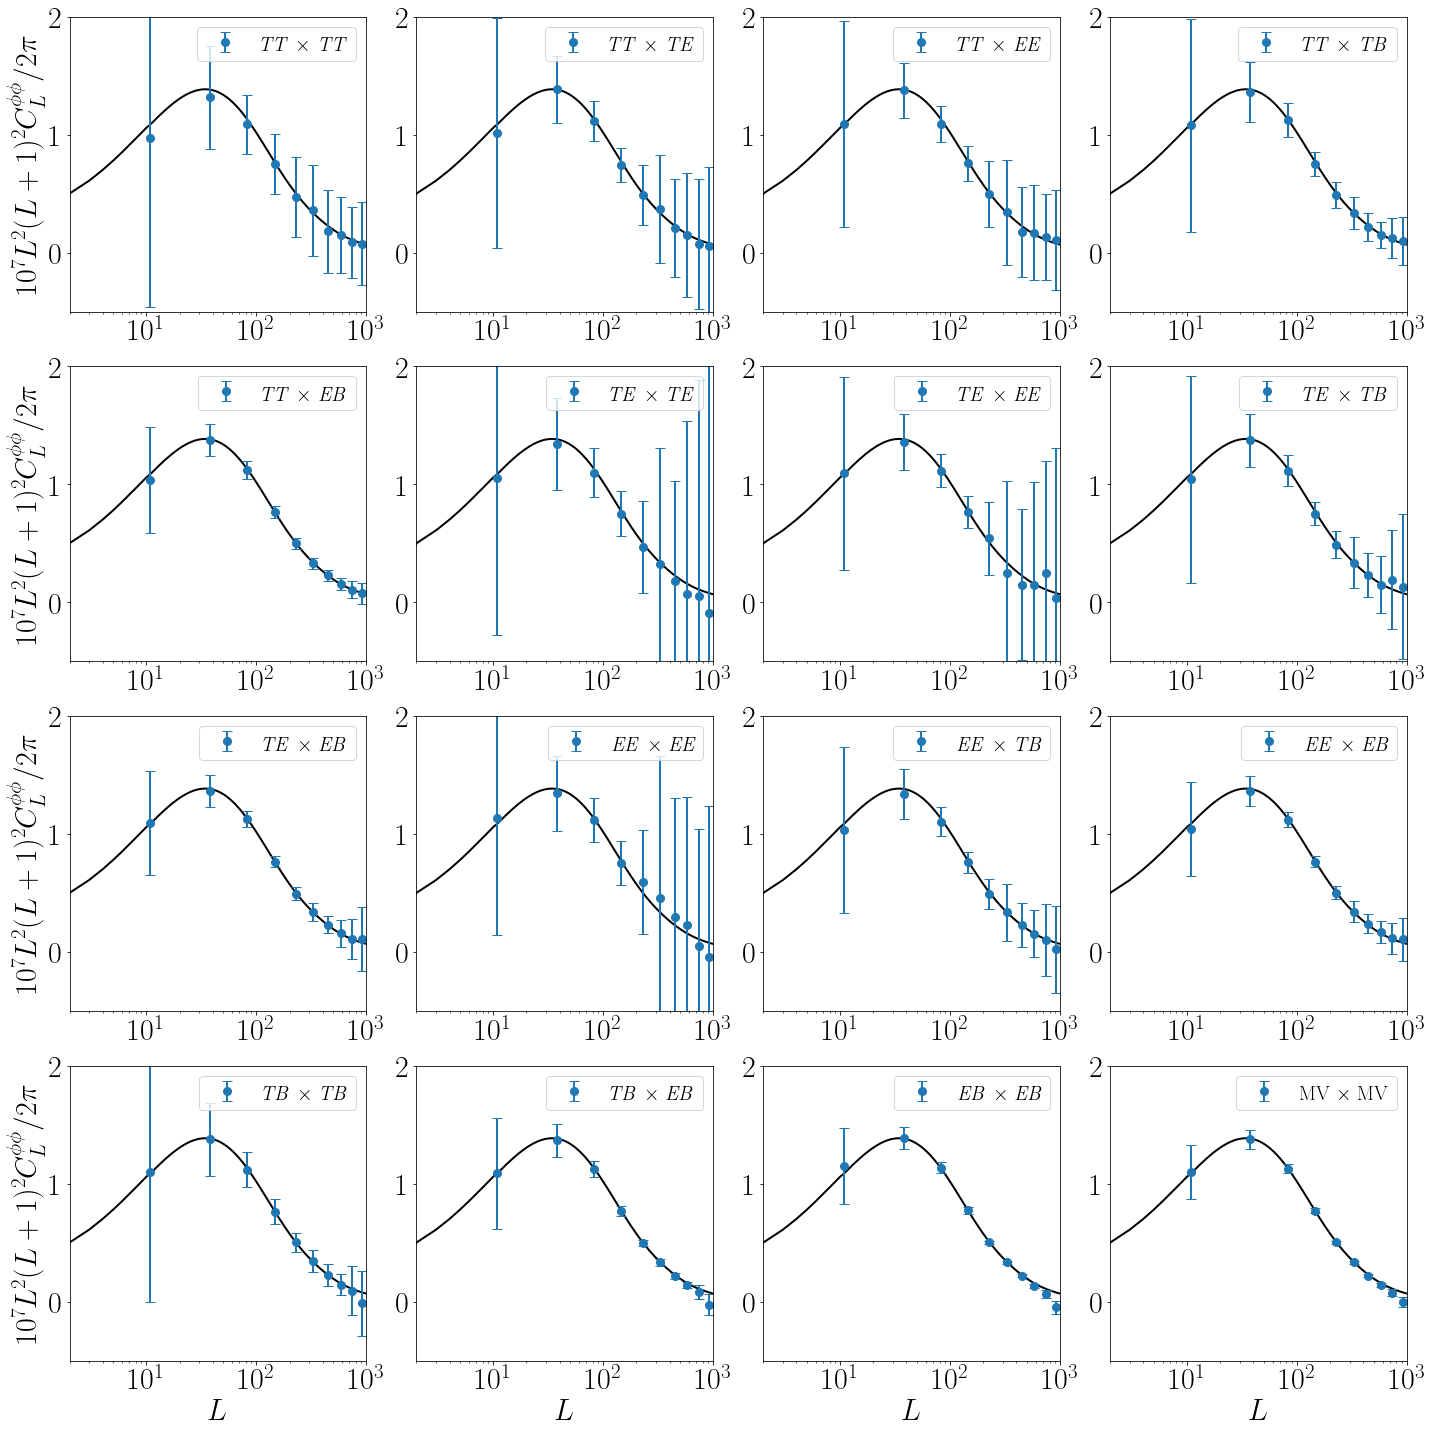

In [9]:
directory_plots = f'{PATH_PACKAGE}/notebooks/plots'
B = B_LB
clb = c_L_b_LiteBIRD
fg_index = 1
lmax = lmax_LB

# Create a 4x4 grid of subplots
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
# Flatten the 2D array of subplots for easier iteration
axs = axs.flatten()

# Iterate over subplots and plot data
for i, (ax, qe) in enumerate(zip(axs, pairs)):
    ax.plot(cls_phiphi*1e7, c='k')  # label=r'$C_L^{\phi\phi}$'
    if qe == 'MVMV':
        ax.errorbar(B, y=np.mean(clb[fg_index][qe]*1e7, axis=0), yerr=np.std(clb[fg_index][qe]*1e7, axis=0),
                    fmt='o', capsize=5, markersize=8, label=f"{qe[:2]} " + r"$\times$" + f" {qe[2:]}")
    else:
        ax.errorbar(B, y=np.mean(clb[fg_index][qe]*1e7, axis=0), yerr=np.std(clb[fg_index][qe]*1e7, axis=0),
                    fmt='o', capsize=5, markersize=8, label='\\textit{'+f"{qe[:2]} "+ '}' + r"$\times$" + ' \\textit{'+f"{qe[2:]} "+ '}')
    ax.set_xscale('log')
    ax.set_yscale('linear')
    ax.legend(ncol=1, loc='upper right', fontsize=20)
    ax.set_xlim([2, lmax])
    ax.set_ylim([-0.5, 2])
    ax.semilogx()
    # ax.semilogy()

    # Show x-label only for the bottom row
    if i < 12:  # Top three rows (0-11)
        ax.set_xlabel("")
    else:  # Bottom row (12-15)
        ax.set_xlabel(r'$L$', size=30)

    # Show y-label only for the left column
    if i % 4 != 0:  # Columns other than the first (1, 2, 3...)
        ax.set_ylabel("")
    else:  # First column (0, 4, 8, 12)
        ax.set_ylabel(r'$10^7L^2(L+1)^2 C_L^{\phi\phi}/2\pi$', size=30)

    # Set tick parameters
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.tick_params(axis='both', which='minor', labelsize=30)

plt.tight_layout()

plt.savefig(f'{directory_plots}/qcl_debiased_LiteBIRD_simple_foregrounds.pdf')

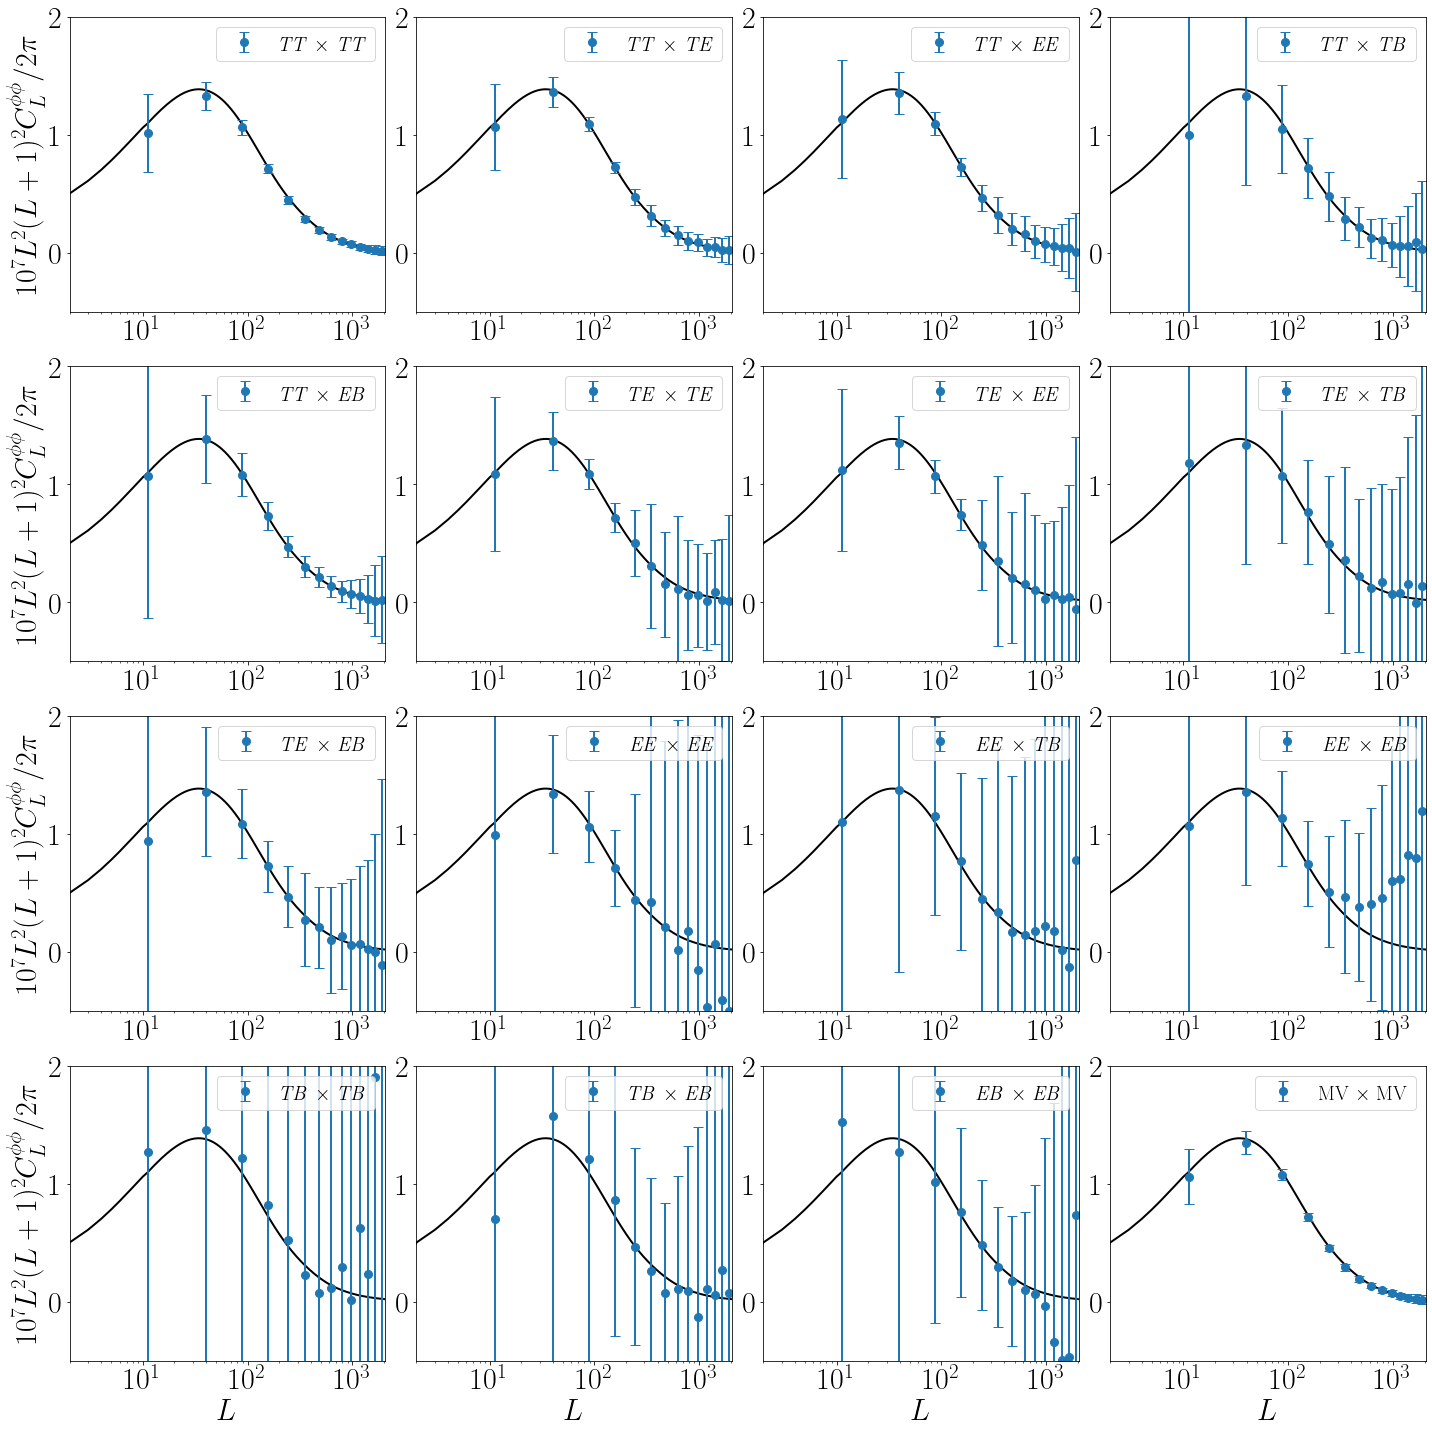

In [10]:
B = B_P
clb = c_L_b_Planck
fg_index = 1
lmax = lmax_P

# Create a 4x4 grid of subplots
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
# Flatten the 2D array of subplots for easier iteration
axs = axs.flatten()

# Iterate over subplots and plot data
for i, (ax, qe) in enumerate(zip(axs, pairs)):
    ax.plot(cls_phiphi*1e7, c='k')  # label=r'$C_L^{\phi\phi}$'
    if qe == 'MVMV':
        ax.errorbar(B, y=np.mean(clb[fg_index][qe]*1e7, axis=0), yerr=np.std(clb[fg_index][qe]*1e7, axis=0),
                    fmt='o', capsize=5, markersize=8, label=f"{qe[:2]} " + r"$\times$" + f" {qe[2:]}")
    else:
        ax.errorbar(B, y=np.mean(clb[fg_index][qe]*1e7, axis=0), yerr=np.std(clb[fg_index][qe]*1e7, axis=0),
                    fmt='o', capsize=5, markersize=8, label='\\textit{'+f"{qe[:2]} "+ '}' + r"$\times$" + ' \\textit{'+f"{qe[2:]} "+ '}')
    ax.set_xscale('log')
    ax.set_yscale('linear')
    ax.legend(ncol=1, loc='upper right', fontsize=20)
    ax.set_xlim([2, lmax])
    ax.set_ylim([-0.5, 2])
    # ax.semilogy()

    # Show x-label only for the bottom row
    if i < 12:  # Top three rows (0-11)
        ax.set_xlabel("")
    else:  # Bottom row (12-15)
        ax.set_xlabel(r'$L$', size=30)

    # Show y-label only for the left column
    if i % 4 != 0:  # Columns other than the first (1, 2, 3...)
        ax.set_ylabel("")
    else:  # First column (0, 4, 8, 12)
        ax.set_ylabel(r'$10^7L^2(L+1)^2 C_L^{\phi\phi}/2\pi$', size=30)

    # Set tick parameters
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.tick_params(axis='both', which='minor', labelsize=30)

plt.tight_layout()

plt.savefig(f'{directory_plots}/qcl_debiased_Planck_simple_foregrounds.pdf')

[]

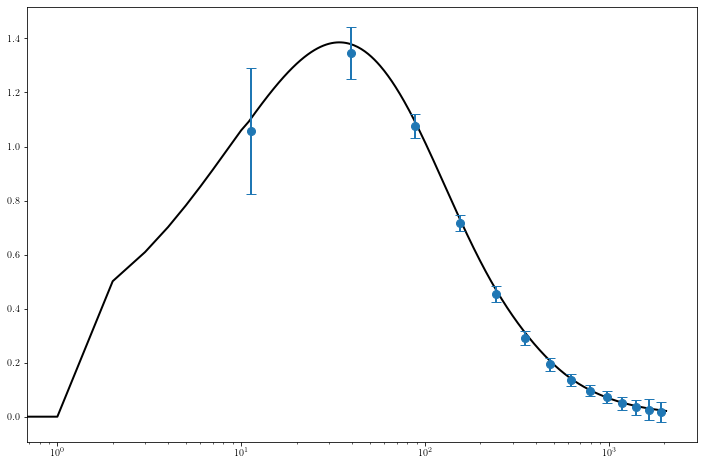

In [11]:
plt.figure()
plt.plot(cls_phiphi*1e7, c='k')  # label=r'$C_L^{\phi\phi}$'
plt.errorbar(B, y=np.mean(clb[fg_index][qe]*1e7, axis=0), yerr=np.std(clb[fg_index][qe]*1e7, axis=0),
                    fmt='o', capsize=5, markersize=8, label=f"{qe[:2]} " + r"$\times$" + f" {qe[2:]}")
plt.semilogx()

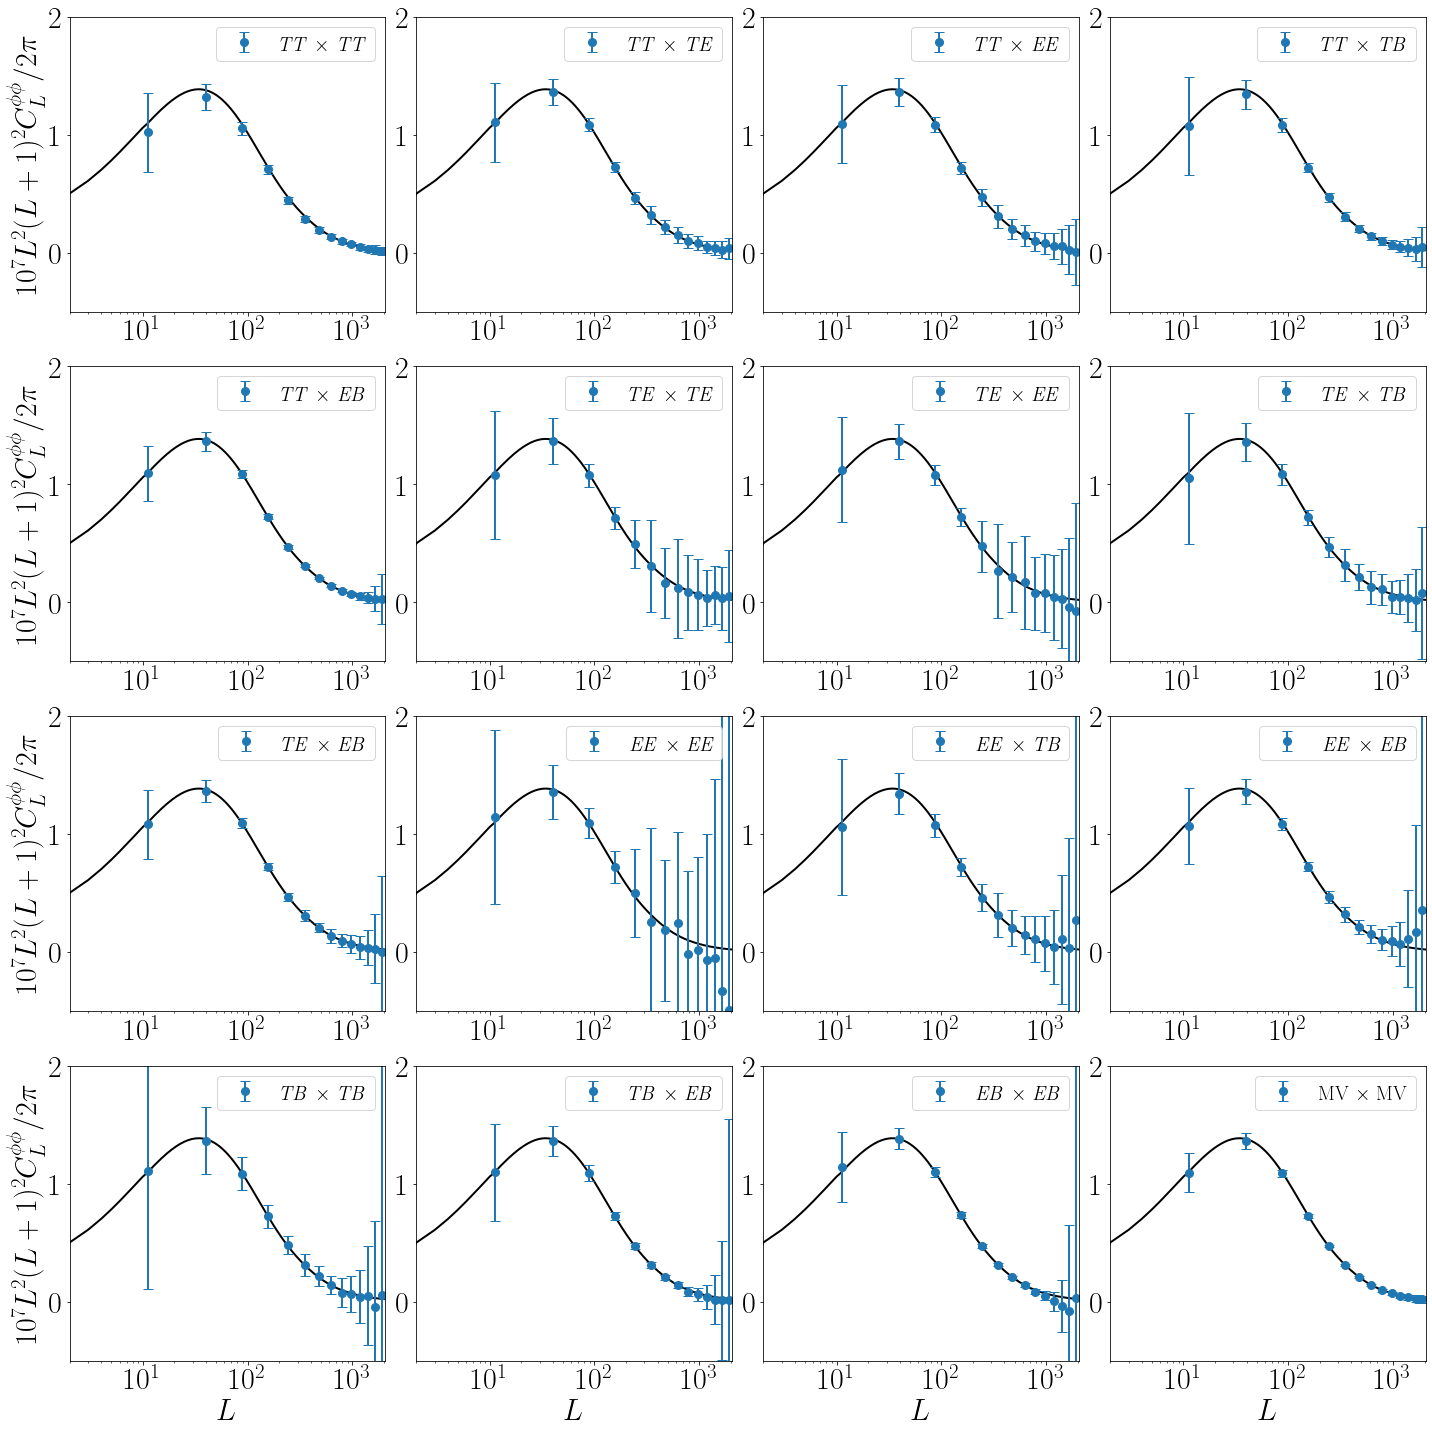

In [12]:
B = B_P
clb = c_L_b_Planck_LiteBIRD
fg_index = 1
lmax = lmax_P

# Create a 4x4 grid of subplots
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
# Flatten the 2D array of subplots for easier iteration
axs = axs.flatten()

# Iterate over subplots and plot data
for i, (ax, qe) in enumerate(zip(axs, pairs)):
    ax.plot(cls_phiphi*1e7, c='k')  # label=r'$C_L^{\phi\phi}$'
    if qe == 'MVMV':
        ax.errorbar(B, y=np.mean(clb[fg_index][qe]*1e7, axis=0), yerr=np.std(clb[fg_index][qe]*1e7, axis=0),
                    fmt='o', capsize=5, markersize=8, label=f"{qe[:2]} " + r"$\times$" + f" {qe[2:]}")
    else:
        ax.errorbar(B, y=np.mean(clb[fg_index][qe]*1e7, axis=0), yerr=np.std(clb[fg_index][qe]*1e7, axis=0),
                    fmt='o', capsize=5, markersize=8, label='\\textit{'+f"{qe[:2]} "+ '}' + r"$\times$" + ' \\textit{'+f"{qe[2:]} "+ '}')
    ax.set_xscale('log')
    ax.set_xscale('log')
    ax.set_yscale('linear')
    ax.legend(ncol=1, loc='upper right', fontsize=20)
    ax.set_xlim([2, lmax])
    ax.set_ylim([-0.5, 2])
    # ax.semilogx()
    # ax.semilogy()

    # Show x-label only for the bottom row
    if i < 12:  # Top three rows (0-11)
        ax.set_xlabel("")
    else:  # Bottom row (12-15)
        ax.set_xlabel(r'$L$', size=30)

    # Show y-label only for the left column
    if i % 4 != 0:  # Columns other than the first (1, 2, 3...)
        ax.set_ylabel("")
    else:  # First column (0, 4, 8, 12)
        ax.set_ylabel(r'$10^7L^2(L+1)^2 C_L^{\phi\phi}/2\pi$', size=30)

    # Set tick parameters
    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.tick_params(axis='both', which='minor', labelsize=30)

plt.tight_layout()
plt.savefig(f'{directory_plots}/qcl_debiased_Planck_LiteBIRD_simple_foregrounds.pdf')

[]

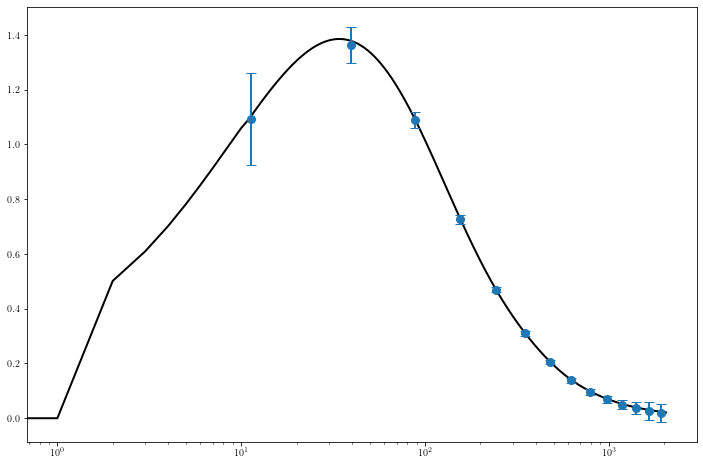

In [14]:
plt.figure()
plt.plot(cls_phiphi*1e7, c='k')  # label=r'$C_L^{\phi\phi}$'
plt.errorbar(B_P, y=np.mean(c_L_b_Planck_LiteBIRD[fg_index][qe]*1e7, axis=0), yerr=np.std(c_L_b_Planck_LiteBIRD[fg_index][qe]*1e7, axis=0),
                    fmt='o', capsize=5, markersize=8, label=f"{qe[:2]} " + r"$\times$" + f" {qe[2:]}")
plt.semilogx()

# Comparing binned lensing power spectra

In [15]:
fd = f'{PATH_PACKAGE}/data/binned_lensing_power_spectrum'
fg_arr = ['no_fg', 's1_d1_f1_a1_co1', 's5_d10_a1_f1_co3']
fname_LiteBIRD = f"LiteBIRD_fsky_0.8"
fname_Planck = f"Planck_fsky_0.7"
fname_Planck_LiteBIRD = f"LiteBIRD_Planck_fsky_0.8"

# Load the amplitudes
amp_binned_LiteBIRD_N_10 = pl.load(open(f"{fd}/amp_binned_LiteBIRD_N_10.pkl", "rb"))
amp_binned_Planck_N_10 = pl.load(open(f"{fd}/amp_binned_Planck_N_10.pkl", "rb"))
amp_binned_Planck_LiteBIRD_N_10 = pl.load(open(f"{fd}/amp_binned_Planck_LiteBIRD_N_10.pkl", "rb"))

In [16]:
# Initialize the variables
amp_binned_LiteBIRD_N_10 = pl.load(open(f"{fd}/amp_binned_LiteBIRD_N_10.pkl", "rb"))
amp_binned_Planck_N_10 = pl.load(open(f"{fd}/amp_binned_Planck_N_10.pkl", "rb"))
amp_binned_Planck_LiteBIRD_N_10 = pl.load(open(f"{fd}/amp_binned_Planck_LiteBIRD_N_10.pkl", "rb"))

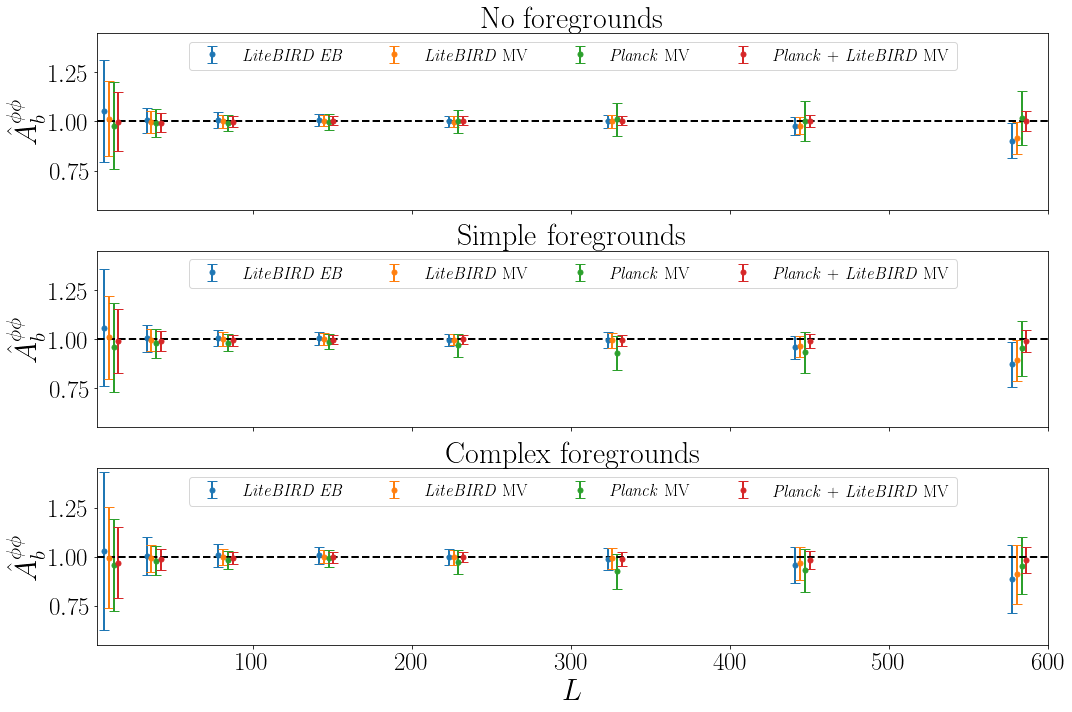

In [18]:
fg_latex = ['No foregrounds', 'Simple foregrounds', 'Complex foregrounds']
fg_indices = [0, 1, 2]  # Example indices for different foreground complexities
n_bins_max = 10
fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

for i, fg_index in enumerate(fg_indices):
    ax = axes[i]

    ax.errorbar(B_LB[:n_bins_max]-4.5, 
                y=np.mean(amp_binned_LiteBIRD_N_10[fg_index]['EBEB'], axis=0)[:n_bins_max],
                yerr=np.std(amp_binned_LiteBIRD_N_10[fg_index]['EBEB'], axis=0)[:n_bins_max],
                fmt='o', capsize=5, markersize=5, label="\\textit{LiteBIRD EB}")
    
    ax.errorbar(B_LB[:n_bins_max]-1.5, 
                y=np.mean(amp_binned_LiteBIRD_N_10[fg_index]['MVMV'], axis=0)[:n_bins_max],
                yerr=np.std(amp_binned_LiteBIRD_N_10[fg_index]['MVMV'], axis=0)[:n_bins_max],
                fmt='o', capsize=5, markersize=5, label="\\textit{LiteBIRD} MV")
    
    ax.errorbar(B_LB[:n_bins_max]+1.5, 
                y=np.mean(amp_binned_Planck_N_10[fg_index]['MVMV'], axis=0)[:n_bins_max],
                yerr=np.std(amp_binned_Planck_N_10[fg_index]['MVMV'], axis=0)[:n_bins_max],
                fmt='o', capsize=5, markersize=5, label="\\textit{Planck} MV")
    
    ax.errorbar(B_LB[:n_bins_max]+4.5, 
                y=np.mean(amp_binned_Planck_LiteBIRD_N_10[fg_index]['MVMV'], axis=0)[:n_bins_max],
                yerr=np.std(amp_binned_Planck_LiteBIRD_N_10[fg_index]['MVMV'], axis=0)[:n_bins_max],
                fmt='o', capsize=5, markersize=5, label="\\textit{Planck} + \\textit{LiteBIRD} MV")
    
    ax.axhline(y=1.0, linestyle='dashed', c='k')
    ax.set_xlim([2, 600])
    ax.set_ylim([0.55, 1.45])
    ax.set_ylabel(r'$\hat{A}_{b}^{\phi\phi}$', size=30)
    ax.tick_params(axis='both', which='major', labelsize=15)
    ax.legend(ncol=4, fontsize=17, loc='upper center')
    ax.tick_params(axis='both', which='major', labelsize=25)
    ax.tick_params(axis='both', which='minor', labelsize=25)
    ax.set_title(f"{fg_latex[i]}", size=30)

axes[-1].set_xlabel(r'$L$', size=30)

plt.tight_layout()
plt.savefig(f'{directory_plots}/bandpowers_A_L_b_all_fg.pdf')


# Calculating the SNR using amp from simulations

In [20]:
num_bins_LB = 10
num_bins_P = 14

In [21]:
def A_lens_calculator(qcl_input, nbins_cut):
    """
    Alens calculator.
    """
    from utils import analysis as ana
    qe_list_MV = qe_list + ['MV']
    # Calculate the SNR
    A_lens = {qe: None for qe in qe_list_MV}

    for i in tqdm(range(len(qe_list_MV))):
        stat = ana.statistics(ocl=1.,scl=qcl_input[qe_list_MV[i]+qe_list_MV[i]][:, :nbins_cut+1])
        stat.get_amp(fcl=1.0, diag=False)
        # stat.get_amp(fcl=qcl_input[qe_list_MV[i]+qe_list_MV[i]][:, :nbins_cut].mean(axis=0), diag=False)
        A_lens[qe_list_MV[i]] = stat.A
                
    return A_lens

def SN_calculator(qcl_input, num_bins):
    """
    Using all the bins, check how the signal to noise changes by incrementing the number of 
    simulations.
    """
    from utils import analysis as ana
    qe_list_MV = qe_list + ['MV']
    # Calculate the SNR
    SN_full = {qe: np.zeros(num_bins) for qe in qe_list_MV}

    for i in tqdm(range(len(qe_list_MV))):
        SN_full[qe_list_MV[i]][0] = 1/np.std(qcl_input[qe_list_MV[i]+qe_list_MV[i]][:, 0])
        for nbins_cut in range(1, num_bins):
            stat = ana.statistics(ocl=1.,scl=qcl_input[qe_list_MV[i]+qe_list_MV[i]][:, :nbins_cut+1])
            stat.get_amp(fcl=1.0, diag=False)
            # stat.get_amp(fcl=qcl_input[qe_list_MV[i]+qe_list_MV[i]][:, :nbins_cut].mean(axis=0), diag=False)
            SN_full[qe_list_MV[i]][nbins_cut] = 1/stat.sA
                
    return SN_full

def SN_calculator_incremental(qcl_input, step, diag=False):
    """
    Using all the bins, check how the signal to noise changes by incrementing the number of 
    simulations.
    """
    from utils import analysis as ana
    qe_list_MV = qe_list + ['MV']
    Nstep = Nsim//step
    SN_full = {qe: np.zeros((Nstep)) for qe in qe_list_MV}

    for i in tqdm(range(len(qe_list_MV))):
        for Nsim_Step in range(1, Nstep+1):
            stat = ana.statistics(ocl=1.,scl=qcl_input[qe_list_MV[i]+qe_list_MV[i]][:Nsim_Step*step, :])
            # stat.get_amp(fcl=qcl_input[qe_list_MV[i]+qe_list_MV[i]].mean(axis=0), diag=False)
            stat.get_amp(fcl=1.0, diag=diag)
            SN_full[qe_list_MV[i]][Nsim_Step-1] = stat.sA
    return SN_full

def SN_calculator_steps(qcl_input, step, diag=False):
    """
    Using all the bins, check how the signal to noise changes by incrementing the number of 
    simulations.
    """
    from utils import analysis as ana
    qe_list_MV = qe_list + ['MV']
    Nstep = Nsim//step
    SN_full = {qe: np.zeros((Nstep)) for qe in qe_list_MV}
    std_SN = {qe: 0.0 for qe in qe_list_MV}

    for i in tqdm(range(len(qe_list_MV))):
        for Nsim_Step in range(1, Nstep+1):
            stat = ana.statistics(ocl=1.,scl=qcl_input[qe_list_MV[i]+qe_list_MV[i]][(Nsim_Step-1)*step:Nsim_Step*step, :])
            # stat.get_amp(fcl=qcl_input[qe_list_MV[i]+qe_list_MV[i]].mean(axis=0), diag=False)
            stat.get_amp(fcl=1.0, diag=diag)
            SN_full[qe_list_MV[i]][Nsim_Step-1] = 1/stat.sA
        std_SN[qe_list_MV[i]] = np.std(SN_full[qe_list_MV[i]])#/np.sqrt(Nsim/step)
    return std_SN # , SN_diag

In [22]:
fd = f'{PATH_PACKAGE}/data/binned_lensing_power_spectrum'
fg_arr = ['no_fg', 's1_d1_f1_a1_co1', 's5_d10_a1_f1_co3']
fname_LiteBIRD = f"LiteBIRD_fsky_0.8"
fname_Planck = f"Planck_fsky_0.7"
fname_Planck_LiteBIRD = f"LiteBIRD_Planck_fsky_0.8"

# Initialize the variables
amp_binned_LiteBIRD = []
amp_binned_Planck = []
amp_binned_Planck_LiteBIRD = []
for i, fg in enumerate(fg_arr):
    # MV weights
    amp_binned_LiteBIRD_aux = pl.load(open(f"{fd}/amp_l_debiased_MC_norm_binned_TT_TE_EE_TB_EB_{fg}_{fname_LiteBIRD}_MV.pkl",'rb'))
    amp_binned_Planck_aux = pl.load(open(f"{fd}/amp_l_debiased_MC_norm_binned_TT_TE_EE_TB_EB_{fg}_{fname_Planck}_MV.pkl",'rb'))
    amp_binned_Planck_LiteBIRD_aux = pl.load(open(f"{fd}/amp_l_debiased_MC_norm_binned_TT_TE_EE_TB_EB_{fg}_{fname_Planck_LiteBIRD}_MV.pkl",'rb'))
    
    amp_binned_LiteBIRD.append({qe: amp_binned_LiteBIRD_aux[qe] for qe in pairs})
    amp_binned_Planck.append({qe: amp_binned_Planck_aux[qe] for qe in pairs})
    amp_binned_Planck_LiteBIRD.append({qe: amp_binned_Planck_LiteBIRD_aux[qe] for qe in pairs})

In [23]:
# Initialize the variables
SN_LiteBIRD = []
SN_Planck = []
SN_Planck_LiteBIRD = []
for i, fg in enumerate(fg_arr):
    SN_LiteBIRD.append(SN_calculator(amp_binned_LiteBIRD[i], num_bins_LB))
    SN_Planck.append(SN_calculator(amp_binned_Planck[i], num_bins_P))
    SN_Planck_LiteBIRD.append(SN_calculator(amp_binned_Planck_LiteBIRD[i], num_bins_P))

100%|█████████████████████████████████████████████| 6/6 [00:04<00:00,  1.31it/s]


In [24]:
def round_w_error(quantity, relat_error=0.04):
    error = np.abs(quantity*relat_error)
    if (error >= 200) & (error < 2000):
        x = int(np.round(quantity, -2))
        string = f"{x:.0f}"
    if (error >= 20) & (error < 200):
        x = int(np.round(quantity, -1))
        string = f"{x:.0f}"
    if (error >= 2) & (error < 20):
        x = int(np.round(quantity, 0))
        string = f"{x:.0f}"
    if (error >= 0.2) & (error < 2):
        x = np.round(quantity, 1)
        string = f"{x:.1f}"
    if (error >= 0.02) & (error < 0.2):
        x = np.round(quantity, 2)
        string = f"{x:.2f}"
    if (error >= 0.002) & (error < 0.02):
        x = np.round(quantity, 3)
        string = f"{x:.3f}"
    if (error >= 0.0002) & (error < 0.002):
        x = np.round(quantity, 4)
        string = f"{x:.4f}"
    return string   

def round_w_error_imp(quantity, relat_error=0.04):
    sign = np.sign(quantity*relat_error)
    error = np.abs(quantity*relat_error)
    if (error >= 200) & (error < 2000):
        x = int(np.round(quantity, -2))
        string = f"{np.abs(x):.0f}"
    if (error >= 20) & (error < 200):
        x = int(np.round(quantity, -1))
        string = f"{np.abs(x):.0f}"
    if (error >= 2) & (error < 20):
        x = int(np.round(quantity, 0))
        string = f"{np.abs(x):.0f}"
    if (error >= 0.2) & (error < 2):
        x = np.round(quantity, 1)
        string = f"{np.abs(x):.1f}"
    if (error >= 0.02) & (error < 0.2):
        x = np.round(quantity, 2)
        string = f"{np.abs(x):.2f}"
    if (error >= 0.002) & (error < 0.02):
        x = np.round(quantity, 3)
        string = f"{np.abs(x):.3f}"
    if (error >= 0.0002) & (error < 0.002):
        x = np.round(quantity, 4)
        string = f"{np.abs(x):.4f}"
        
    if sign == -1:
        string = '$-$'+string+'\phantom{$-$}'
    if sign == 1:
        string = '$+$'+string+'\phantom{$+$}'
    return string   

In [26]:
# Define the Quadratic Estimators (QE) and experiments
QEs = ["TT", "EE", "TE", "TB", "EB", "MV"]
experiments = ["Planck", "LiteBIRD", "Planck + LiteBIRD"]

print('                no fg', '    Low complexity','    Medium complexity')

for j, qe in enumerate(QEs):
    print('\multirow{4}{*}{', f'${qe}$', '} & ', '\\textit{Planck} &', round_w_error(SN_Planck[0][qe][-1]), '&', round_w_error(SN_Planck[1][qe][-1]), '&', round_w_error(SN_Planck[2][qe][-1]), '\\\\')
    print('& \\textit{LiteBIRD}', f" &", round_w_error(SN_LiteBIRD[0][qe][-1]), '&', round_w_error(SN_LiteBIRD[1][qe][-1]), '&', round_w_error(SN_LiteBIRD[2][qe][-1]), '\\\\')
    print('& \\textit{Planck} + \\textit{LiteBIRD}', f" &", round_w_error(SN_Planck_LiteBIRD[0][qe][-1]), '&', round_w_error(SN_Planck_LiteBIRD[1][qe][-1]), '&', round_w_error(SN_Planck_LiteBIRD[2][qe][-1]), '\\\\')
    print('\hhline{~----}')
    print('& \% improvement', f" & ", round_w_error_imp(100*(SN_Planck_LiteBIRD[0][qe][-1]/SN_LiteBIRD[0][qe][-1]-1)), '&',
          round_w_error_imp(100*(SN_Planck_LiteBIRD[1][qe][-1]/SN_LiteBIRD[1][qe][-1]-1)), '&',
          round_w_error_imp(100*(SN_Planck_LiteBIRD[2][qe][-1]/SN_LiteBIRD[2][qe][-1]-1)), "\\\\")
    print('\hline')
    # print('----------------------------------------')

                no fg     Low complexity     Medium complexity
\multirow{4}{*}{ $TT$ } &  \textit{Planck} & 35.4 & 35.0 & 33.8 \\
& \textit{LiteBIRD}  & 6.5 & 6.0 & 5.9 \\
& \textit{Planck} + \textit{LiteBIRD}  & 37.3 & 36.7 & 35.5 \\
\hhline{~----}
& \% improvement  &  $+$470\phantom{$+$} & $+$510\phantom{$+$} & $+$497\phantom{$+$} \\
\hline
\multirow{4}{*}{ $EE$ } &  \textit{Planck} & 5.5 & 5.2 & 4.79 \\
& \textit{LiteBIRD}  & 8.9 & 8.5 & 8.4 \\
& \textit{Planck} + \textit{LiteBIRD}  & 12.2 & 11.8 & 11.7 \\
\hhline{~----}
& \% improvement  &  $+$37.3\phantom{$+$} & $+$38.3\phantom{$+$} & $+$39.7\phantom{$+$} \\
\hline
\multirow{4}{*}{ $TE$ } &  \textit{Planck} & 12.4 & 11.8 & 11.4 \\
& \textit{LiteBIRD}  & 8.1 & 7.7 & 7.4 \\
& \textit{Planck} + \textit{LiteBIRD}  & 15.7 & 15.2 & 15.0 \\
\hhline{~----}
& \% improvement  &  $+$95\phantom{$+$} & $+$98\phantom{$+$} & $+$101\phantom{$+$} \\
\hline
\multirow{4}{*}{ $TB$ } &  \textit{Planck} & 0.470 & 0.408 & 0.377 \\
& \textit{LiteBIRD}  &

/tmp/ipykernel_14130/2227061005.py:44: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


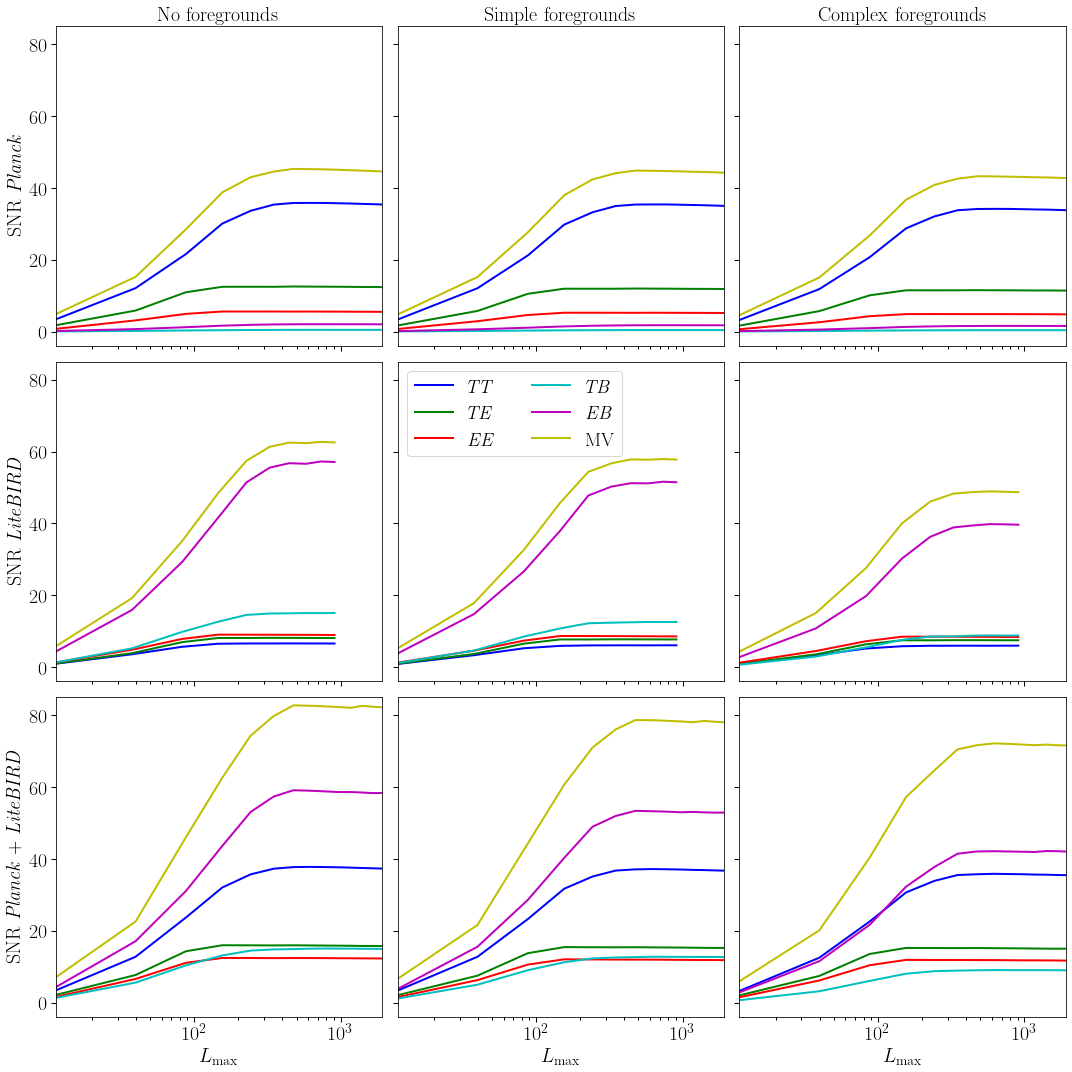

In [28]:
fg_latex = ['No foregrounds', 'Simple foregrounds', 'Complex foregrounds']
fig, axes = plt.subplots(3, 3, figsize=(15, 15), constrained_layout=True, sharex=True, sharey=True)

# Experiments and their corresponding data
experiments = [
    ("\\textit{Planck}", B_P, SN_Planck),
    ("\\textit{LiteBIRD}", B_LB, SN_LiteBIRD),
    ("\\textit{Planck} + \\textit{LiteBIRD}", B_P, SN_Planck_LiteBIRD),
]

# Iterate over rows (experiments) and columns (foreground complexities)
for row, (experiment_name, L_values, SN_data) in enumerate(experiments):
    for col in range(3):  # Foreground complexities
        ax = axes[row, col]
        for i, qe in enumerate(qe_list_MV):
            if qe == 'MV':
                ax.plot(L_values, SN_data[col][qe], label=f"{qe}", c=c[i])
            else:
                ax.plot(L_values, SN_data[col][qe], label='\\textit{'+f"{qe}"+'}', c=c[i])
        
        # Axis settings
        ax.set_xlim([B_P[0], B_P[-1]])
        ax.set_ylim([-4, 85])
        ax.set_xscale('log')
        ax.set_yscale('linear')
        ax.tick_params(axis='both', length=5, width=1, which='major', labelsize=20)
        ax.tick_params(axis='both', length=3, width=1, which='minor', labelsize=20)
        # Set gridlines only on even ticks
        # ax.grid(which="both")
        
        # Use a custom tick locator for even ticks
        # even_tick_locator = LogLocator(base=10.0, subs=(2, 4, 6, 8), numticks=10)
        # ax.xaxis.set_minor_locator(even_tick_locator)
        if row == 2:
            ax.set_xlabel(r'$L_{\rm max}$', size=20)  # Only for bottom row
        if col == 0:
            ax.set_ylabel(f'SNR {experiment_name}', size=20)  # Only for leftmost column
        if row==0:
            # Title for the subplot
            ax.set_title(f"{fg_latex[col]}", size=20)
        if row==1 and col == 1:
            ax.legend(ncol=2, loc='upper left', fontsize=19)  # Only for one subplot

plt.tight_layout()
plt.savefig(f'{directory_plots}/SNR_all_exp_fg.pdf')

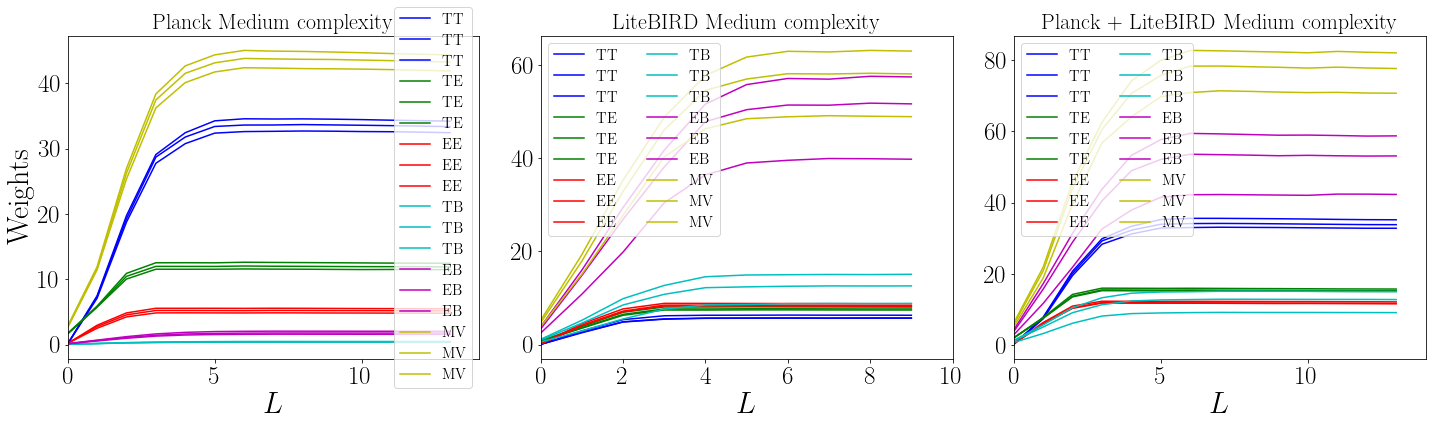

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6), constrained_layout=True)  # Three columns

c = ['b', 'g', 'r', 'c', 'm', 'y']
# First subplot
ax = axes[0]
for i, qe in enumerate(qe_list_MV):
    for fg_i in range(3):
        ax.plot(SN_Planck[fg_i][qe], label=f"{qe}", c=c[i])
ax.set_xlim([0, num_bins_P])
# ax.set_ylim([-0.1, 1])
ax.set_xlabel(r'$L$', size=30)
ax.set_ylabel(r'Weights', size=30)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.tick_params(axis='both', which='minor', labelsize=25)
ax.set_xscale('linear')
ax.set_yscale('linear')
ax.legend(ncol=1, loc='center right', fontsize=15)
ax.set_title("Planck Medium complexity", size=22)

# Second subplot
ax = axes[1]
for i, qe in enumerate(qe_list_MV):
    for fg_i in range(3):
        ax.plot(SN_LiteBIRD[fg_i][qe], label=f"{qe}", c=c[i])
ax.set_xlim([0, num_bins_LB])
# ax.set_ylim([-0.1, 1])
ax.set_xlabel(r'$L$', size=30)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.tick_params(axis='both', which='minor', labelsize=25)
ax.set_xscale('linear')
ax.set_yscale('linear')
ax.legend(ncol=2, loc='upper left', fontsize=15)
ax.set_title("LiteBIRD Medium complexity", size=22)

# Third subplot
ax = axes[2]
for i, qe in enumerate(qe_list_MV):
    for fg_i in range(3):
        ax.plot(SN_Planck_LiteBIRD[fg_i][qe], label=f"{qe}", c=c[i])
ax.set_xlim([0, num_bins_P])
# ax.set_ylim([-0.1, 1])
ax.set_xlabel(r'$L$', size=30)
ax.tick_params(axis='both', which='major', labelsize=25)
ax.tick_params(axis='both', which='minor', labelsize=25)
# ax.set_xscale('log')
ax.set_yscale('linear')
ax.legend(ncol=2, loc='upper left', fontsize=15)
ax.set_title("Planck + LiteBIRD Medium complexity", size=22)
plt.tight_layout()
# plt.savefig('Weights_MV_Medium_complexity.pdf')

In [29]:
# Initialize the variables
A_lens_LiteBIRD = []
A_lens_Planck = []
A_lens_Planck_LiteBIRD = []
for i, fg in enumerate(fg_arr):
    A_lens_LiteBIRD.append(A_lens_calculator(amp_binned_LiteBIRD[i], 10))
    A_lens_Planck.append(A_lens_calculator(amp_binned_Planck[i], nbins_cut=14))
    A_lens_Planck_LiteBIRD.append(A_lens_calculator(amp_binned_Planck_LiteBIRD[i], nbins_cut=14))

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00,  8.80it/s]


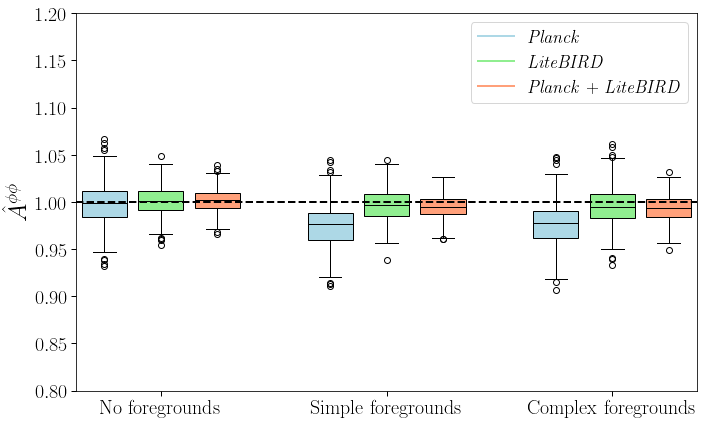

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Example Data: Replace these with your actual data
foregrounds = ['No foregrounds', 'Simple foregrounds', 'Complex foregrounds']  # Foreground scenarios
experiments = ['\\textit{Planck}', '\\textit{LiteBIRD}', '\\textit{Planck} + \\textit{LiteBIRD}']  # Experiments
colors = ['lightblue', 'lightgreen', 'lightsalmon']  # Unique color for each experiment

# Prepare data for boxplot
all_data = []
positions = []
position_offset = 1  # Space between groups of boxes
box_width = 0.8  # Width of individual boxes

for i, fg in enumerate(foregrounds):
    # Append data for each experiment for this foreground complexity
    all_data.append(A_lens_Planck[i]['MV'])
    all_data.append(A_lens_LiteBIRD[i]['MV'])
    all_data.append(A_lens_Planck_LiteBIRD[i]['MV'])
    # Calculate positions for the boxes
    for j in range(len(experiments)):
        positions.append(i * (len(experiments) + position_offset) + j + 1)

# Plot the vertical box plot
plt.figure(figsize=(10, 6))
for idx, experiment_color in enumerate(colors):
    # Select the indices corresponding to each experiment
    exp_indices = range(idx, len(all_data), len(experiments))
    exp_data = [all_data[i] for i in exp_indices]
    exp_positions = [positions[i] for i in exp_indices]

    # Add box plots for this experiment with the corresponding color
    plt.boxplot(exp_data, vert=True, positions=exp_positions, widths=box_width, patch_artist=True,
                boxprops=dict(facecolor=experiment_color, color='black'),
                medianprops=dict(color='black'))

# Add a dashed line at y=1.0
plt.axhline(y=1.0, linestyle='dashed', c='k')

# Set limits, labels, and ticks
plt.tick_params(axis='both', length=5, width=1, which='major', labelsize=20)
plt.tick_params(axis='both', length=3, width=1, which='minor', labelsize=20)
plt.ylim([0.8, 1.2])
xticks = [(i * (len(experiments) + position_offset)) + 2 for i in range(len(foregrounds))]
plt.xticks(xticks, foregrounds, fontsize=20)
plt.ylabel(r'$\hat{A}^{\phi\phi}$', fontsize=25)
# plt.title('Vertical Box Plot: Foreground Scenarios and Experiments', fontsize=16)

# Add a legend for the experiments
handles = [plt.Line2D([0], [0], color=color, lw=2, label=exp) for color, exp in zip(colors, experiments)]
plt.legend(handles, experiments, loc='upper right', fontsize=18)

plt.tight_layout()
plt.savefig('A_lens_MV_all_exp_all_fg.pdf')

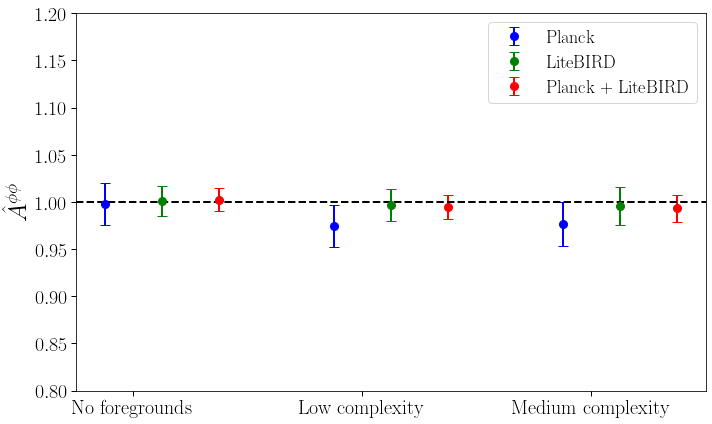

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Example Data: Replace these with your actual data
foregrounds = ['No foregrounds', 'Low complexity', 'Medium complexity']  # Foreground scenarios
experiments = ['Planck', 'LiteBIRD', 'Planck + LiteBIRD']  # Experiments
colors = ['blue', 'green', 'red']  # Unique color for each experiment

# Prepare data for error bars
means = []
stds = []
positions = []
position_offset = 1  # Space between groups
point_offset = 0.2  # Space between points within a group

for i, fg in enumerate(foregrounds):
    # Compute statistics for each experiment
    for j, data in enumerate([A_lens_Planck[i], A_lens_LiteBIRD[i], A_lens_Planck_LiteBIRD[i]]):
        mv_data = data['MV']
        means.append(np.mean(mv_data))
        stds.append(np.std(mv_data))
        positions.append(i * (len(experiments) + position_offset) + j + 1)

# Plot the error bars
plt.figure(figsize=(10, 6))
for idx, (color, exp) in enumerate(zip(colors, experiments)):
    # Extract data for each experiment
    exp_indices = range(idx, len(means), len(experiments))
    exp_means = [means[i] for i in exp_indices]
    exp_stds = [stds[i] for i in exp_indices]
    exp_positions = [positions[i] for i in exp_indices]

    # Plot error bars
    plt.errorbar(exp_positions, exp_means, yerr=exp_stds, fmt='o', color=color, label=exp, capsize=5, markersize=8)

# Add a dashed line at y=1.0
plt.axhline(y=1.0, linestyle='dashed', c='k')

# Set limits, labels, and ticks
plt.tick_params(axis='both', length=5, width=1, which='major', labelsize=20)
plt.tick_params(axis='both', length=3, width=1, which='minor', labelsize=20)
plt.ylim([0.8, 1.2])
xticks = [(i * (len(experiments) + position_offset)) + 1.5 for i in range(len(foregrounds))]
plt.xticks(xticks, foregrounds, fontsize=20)
plt.ylabel(r'$\hat{A}^{\phi\phi}$', fontsize=25)

# Add a legend for the experiments
plt.legend(loc='upper right', fontsize=18)

plt.tight_layout()
# plt.savefig(f'{directory_plots}/A_lens_MV_all_exp_all_fg_errorbar.pdf')

# Bootstrap for error estimation

In [34]:
def SN_error_bootstrap(A_lens):
    """
    Using all the bins, check how the signal to noise changes by incrementing the number of 
    simulations.
    """
    
    from scipy.stats import bootstrap
    qe_list_MV = qe_list + ['MV']
    error_SNR_all_fg = []
    
    for i in range(3):
        error_SNR = {qe: 0.0 for qe in qe_list_MV}
        for j, qe in enumerate(qe_list_MV):
            res = bootstrap((A_lens[i][qe],), np.std, confidence_level=0.68, n_resamples=10000)
            error_SNR[qe] = 100*res.standard_error/np.mean(res.bootstrap_distribution)
        error_SNR_all_fg.append(error_SNR)
    return error_SNR_all_fg

In [35]:
error_LiteBIRD = SN_error_bootstrap(A_lens_LiteBIRD)
error_LiteBIRD[0]['Mean'] = np.mean(np.array(list(error_LiteBIRD[0].values())))
error_LiteBIRD[1]['Mean'] = np.mean(np.array(list(error_LiteBIRD[1].values())))
error_LiteBIRD[2]['Mean'] = np.mean(np.array(list(error_LiteBIRD[2].values())))
error_LiteBIRD

[{'TT': 3.3345668687327117,
  'TE': 3.6469515688956546,
  'EE': 3.52568043205294,
  'TB': 3.7306156411817546,
  'EB': 3.5409772958589616,
  'MV': 3.5459650391541264,
  'Mean': 3.554126140979358},
 {'TT': 3.3686060283046118,
  'TE': 3.7116726380265708,
  'EE': 3.4778533395871443,
  'TB': 3.622160692313274,
  'EB': 3.4533828269715756,
  'MV': 3.411468933497264,
  'Mean': 3.5075240764500735},
 {'TT': 3.258047549735374,
  'TE': 3.7106713374332236,
  'EE': 3.5467665043339194,
  'TB': 3.4649127352748903,
  'EB': 3.642900379166792,
  'MV': 3.8236699471731024,
  'Mean': 3.5744947421862165}]

In [36]:
error_Planck = SN_error_bootstrap(A_lens_Planck)
error_Planck[0]['Mean'] = np.mean(np.array(list(error_Planck[0].values())))
error_Planck[1]['Mean'] = np.mean(np.array(list(error_Planck[1].values())))
error_Planck[2]['Mean'] = np.mean(np.array(list(error_Planck[2].values())))
error_Planck

[{'TT': 3.3344861074597496,
  'TE': 3.4742620499624266,
  'EE': 3.348169137430318,
  'TB': 3.4012766065685995,
  'EB': 3.6324804908866692,
  'MV': 3.6597256139725274,
  'Mean': 3.4750666677133815},
 {'TT': 3.4416856318509375,
  'TE': 3.4205293926650406,
  'EE': 3.470508991278064,
  'TB': 3.5182824293341777,
  'EB': 3.8102986848075,
  'MV': 3.6949549585527808,
  'Mean': 3.5593766814147503},
 {'TT': 3.4087266032462105,
  'TE': 3.404249212422961,
  'EE': 3.5643967930675027,
  'TB': 3.5951198339819923,
  'EB': 3.907790818395665,
  'MV': 3.733057944536699,
  'Mean': 3.602223534275172}]

In [37]:
error_Planck_LiteBIRD = SN_error_bootstrap(A_lens_Planck_LiteBIRD)
error_Planck_LiteBIRD[0]['Mean'] = np.mean(np.array(list(error_Planck_LiteBIRD[0].values())))
error_Planck_LiteBIRD[1]['Mean'] = np.mean(np.array(list(error_Planck_LiteBIRD[1].values())))
error_Planck_LiteBIRD[2]['Mean'] = np.mean(np.array(list(error_Planck_LiteBIRD[2].values())))
error_Planck_LiteBIRD

[{'TT': 3.537946476907748,
  'TE': 3.6637694573603903,
  'EE': 3.2976982312277205,
  'TB': 3.6045622058244806,
  'EB': 3.609815779326141,
  'MV': 3.6873855185484326,
  'Mean': 3.5668629448658185},
 {'TT': 3.5019081034627333,
  'TE': 3.6445228548798787,
  'EE': 3.37781523139101,
  'TB': 3.713215655887474,
  'EB': 3.6529387080449687,
  'MV': 3.457159515111309,
  'Mean': 3.557926678129563},
 {'TT': 3.4950272077369346,
  'TE': 3.7658237917414064,
  'EE': 3.3920579588792332,
  'TB': 3.608560548482505,
  'EB': 3.6464795751780024,
  'MV': 3.273044727694464,
  'Mean': 3.530165634952091}]

In [38]:
from scipy.stats import bootstrap
i = 1
res = bootstrap((A_lens_LiteBIRD[i]['MV'],), np.std, confidence_level=0.68, n_resamples=10000)

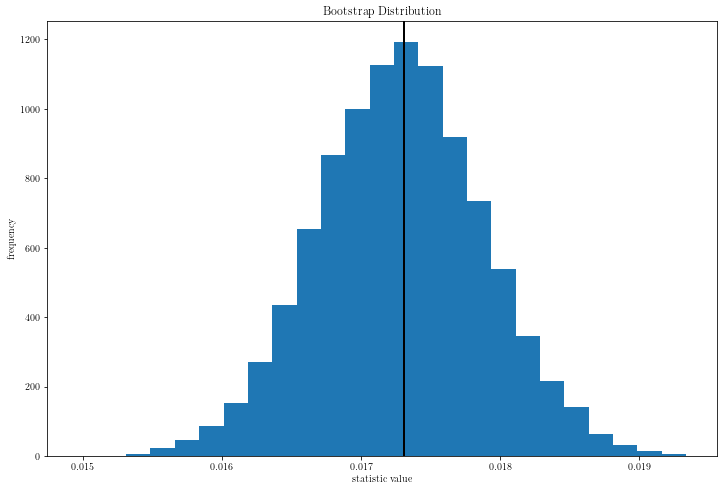

In [39]:
fig, ax = plt.subplots()
ax.hist(res.bootstrap_distribution, bins=25)
plt.axvline(np.std(A_lens_LiteBIRD[i]['MV']), c='k')
ax.set_title('Bootstrap Distribution')
ax.set_xlabel('statistic value')
ax.set_ylabel('frequency')
plt.show()

In [40]:
res.standard_error

0.0005933436474956331

In [41]:
100*np.std(res.bootstrap_distribution)/np.mean(res.bootstrap_distribution)

3.432673552345061

KstestResult(statistic=0.025439375304748935, pvalue=0.9521671679981645, statistic_location=0.35728460936918116, statistic_sign=1)

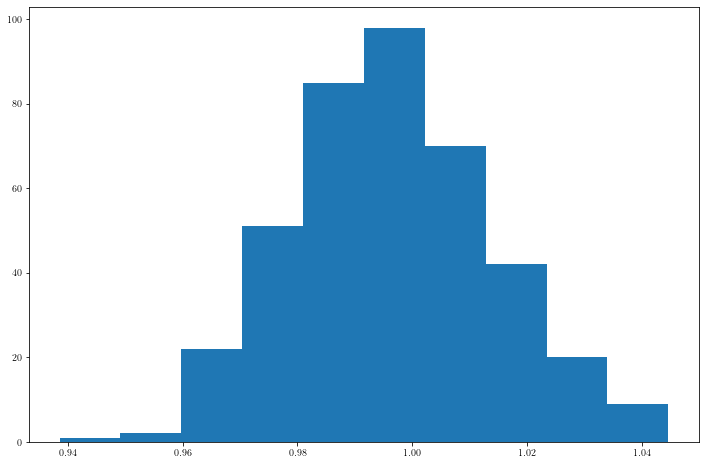

In [42]:
plt.hist(A_lens_LiteBIRD[i]['MV'])
import scipy
scipy.stats.kstest((A_lens_LiteBIRD[i]['MV']-np.mean(A_lens_LiteBIRD[i]['MV']))/np.std(A_lens_LiteBIRD[i]['MV']),
                   scipy.stats.norm.cdf)

KstestResult(statistic=0.03894653677340554, pvalue=0.5652640307118125, statistic_location=0.7259114226163413, statistic_sign=1)

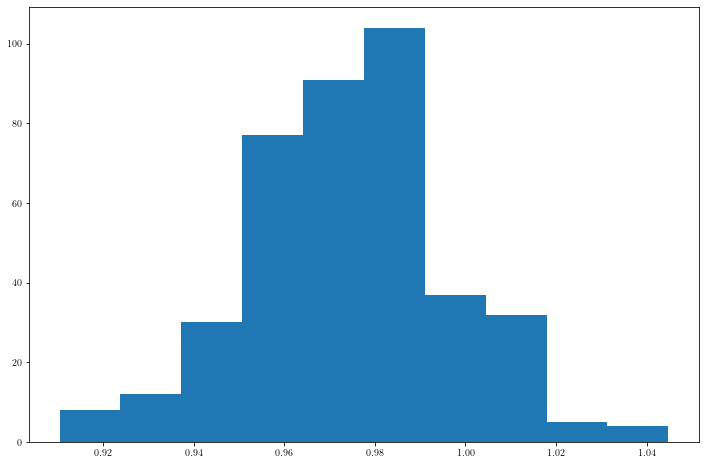

In [43]:
plt.hist(A_lens_Planck[i]['MV'])
scipy.stats.kstest((A_lens_Planck[i]['MV']-np.mean(A_lens_Planck[i]['MV']))/np.std(A_lens_Planck[i]['MV']),
                   scipy.stats.norm.cdf)

KstestResult(statistic=0.03395950900022249, pvalue=0.7322443393915619, statistic_location=0.3346103743819627, statistic_sign=1)

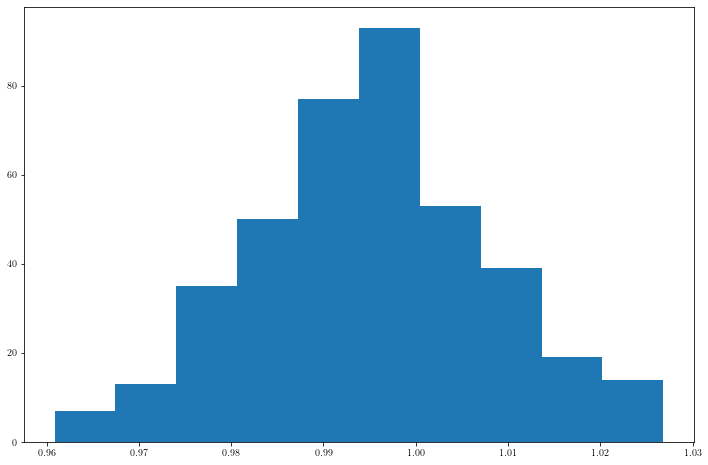

In [44]:
plt.hist(A_lens_Planck_LiteBIRD[i]['MV'])
scipy.stats.kstest((A_lens_Planck_LiteBIRD[i]['MV']-np.mean(A_lens_Planck_LiteBIRD[i]['MV']))/np.std(A_lens_Planck_LiteBIRD[i]['MV']),
                   scipy.stats.norm.cdf)

# Error estimation on the SNR

In [45]:
steps = 100
n = Nsim/steps
diag = True
SN_full_LiteBIRD_steps = []
SN_full_Planck_steps = []
SN_full_LiteBIRD_Planck_steps = []
for i, fg in enumerate(fg_arr):
    SN_full_LiteBIRD_steps.append(SN_calculator_steps(amp_binned_LiteBIRD[i], steps, diag=diag))
    SN_full_Planck_steps.append(SN_calculator_steps(amp_binned_Planck[i], steps, diag=diag))
    SN_full_LiteBIRD_Planck_steps.append(SN_calculator_steps(amp_binned_Planck_LiteBIRD[i], steps, diag=diag))

100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 15.99it/s]


In [46]:
# Define the Quadratic Estimators (QE) and experiments
QEs = ["TT", "EE", "TE", "TB", "EB", "MV"]
experiments = ["Planck", "LiteBIRD", "Planck + LiteBIRD"]

print('                no fg', '    Low complexity','    Medium complexity')

avg_no_fg = 0.0
avg_s1d1 = 0.0
avg_s5d10 = 0.0
for j, qe in enumerate(QEs):
    print('Planck', f"{qe} & ", np.round(100*SN_full_Planck_steps[0][qe]/SN_Planck[0][qe][-1], 1), '&',
                                  np.round(100*SN_full_Planck_steps[1][qe]/SN_Planck[1][qe][-1], 1), '&',
                                  np.round(100*SN_full_Planck_steps[2][qe]/SN_Planck[2][qe][-1], 1), '\\\\')
    avg_no_fg += np.round(100*SN_full_Planck_steps[0][qe]/SN_Planck[0][qe][-1], 1)
    avg_s1d1 += np.round(100*SN_full_Planck_steps[1][qe]/SN_Planck[1][qe][-1], 1)
    avg_s5d10 += np.round(100*SN_full_Planck_steps[2][qe]/SN_Planck[2][qe][-1], 1)
    print('\hline')
    print('LiteBIRD', f"{qe} &", np.round(100*SN_full_LiteBIRD_steps[0][qe]/SN_LiteBIRD[0][qe][-1], 1),
                      '&', np.round(100*SN_full_LiteBIRD_steps[1][qe]/SN_LiteBIRD[1][qe][-1], 1), '&',
                          np.round(100*SN_full_LiteBIRD_steps[2][qe]/SN_LiteBIRD[2][qe][-1], 1), '\\\\')
    avg_no_fg += np.round(100*SN_full_LiteBIRD_steps[0][qe]/SN_LiteBIRD[0][qe][-1], 1),
    avg_s1d1 += np.round(100*SN_full_LiteBIRD_steps[1][qe]/SN_LiteBIRD[1][qe][-1], 1)
    avg_s5d10 += np.round(100*SN_full_LiteBIRD_steps[2][qe]/SN_LiteBIRD[2][qe][-1], 1)
    print('\hline')
    print('Planck + LiteBIRD', f"{qe} &",
              np.round(100*SN_full_LiteBIRD_Planck_steps[0][qe]/SN_Planck_LiteBIRD[0][qe][-1], 1), '&',
          np.round(100*SN_full_LiteBIRD_Planck_steps[1][qe]/SN_Planck_LiteBIRD[1][qe][-1], 1), '&',
          np.round(100*SN_full_LiteBIRD_Planck_steps[2][qe]/SN_Planck_LiteBIRD[2][qe][-1], 1), '\\\\')
    avg_no_fg += np.round(100*SN_full_LiteBIRD_Planck_steps[0][qe]/SN_Planck_LiteBIRD[0][qe][-1], 1)
    avg_s1d1 += np.round(100*SN_full_LiteBIRD_Planck_steps[1][qe]/SN_Planck_LiteBIRD[1][qe][-1], 1)
    avg_s5d10 += np.round(100*SN_full_LiteBIRD_Planck_steps[2][qe]/SN_Planck_LiteBIRD[2][qe][-1], 1)
    print('\hline\hline')
    # print('----------------------------------------')
    
print('avg_no_fg', avg_no_fg/(3*(j+1)))
print('avg_s1d1', avg_s1d1/(3*(j+1)))
print('avg_s5d10', avg_s5d10/(3*(j+1)))

                no fg     Low complexity     Medium complexity
Planck TT &  9.1 & 8.8 & 8.2 \\
\hline
LiteBIRD TT & 7.5 & 8.1 & 9.4 \\
\hline
Planck + LiteBIRD TT & 8.6 & 9.5 & 10.3 \\
\hline\hline
Planck EE &  5.8 & 5.6 & 5.7 \\
\hline
LiteBIRD EE & 7.0 & 5.0 & 5.5 \\
\hline
Planck + LiteBIRD EE & 11.6 & 6.7 & 4.9 \\
\hline\hline
Planck TE &  6.3 & 4.2 & 2.6 \\
\hline
LiteBIRD TE & 6.9 & 11.2 & 10.0 \\
\hline
Planck + LiteBIRD TE & 6.9 & 6.2 & 7.1 \\
\hline\hline
Planck TB &  3.2 & 6.5 & 4.8 \\
\hline
LiteBIRD TB & 5.0 & 9.0 & 7.0 \\
\hline
Planck + LiteBIRD TB & 2.9 & 7.8 & 7.5 \\
\hline\hline
Planck EB &  3.8 & 3.7 & 4.6 \\
\hline
LiteBIRD EB & 6.9 & 4.8 & 3.3 \\
\hline
Planck + LiteBIRD EB & 7.7 & 5.3 & 3.7 \\
\hline\hline
Planck MV &  9.8 & 10.5 & 10.2 \\
\hline
LiteBIRD MV & 6.3 & 4.8 & 6.4 \\
\hline
Planck + LiteBIRD MV & 6.3 & 4.4 & 3.0 \\
\hline\hline
avg_no_fg [6.75555556]
avg_s1d1 6.783333333333334
avg_s5d10 6.344444444444445
